In [21]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import pingouin as pg
# 
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib

import analyze2p.objects.selectivity as sel
import analyze2p.objects.sim_utils as su

In [22]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [23]:
experiment = 'blobs'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
if experiment=='rfs' and responsive_test=='nstds':
    responsive_thr=7.0
else:
    responsive_thr=0.05 if responsive_test=='ROC' else 10.0
print(responsive_test, responsive_thr)
#### Responsive params
responsive_str = '%s_%s-%.2f' % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, responsive_str])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'blobs_%s_%s' % (response_type, responsive_test),
                       'morph_tuning')
print(dst_dir)

ROC 0.05
traces001|dff_ROC-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning


# Load data

In [24]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [25]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking mislabeled
Stimulus: blobs (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |          1252 |
| Lm |          1035 |
| Li |           577 |
|    |   visual_area |
|:---|--------------:|
| Li |            18 |
| Lm |            16 |
| V1 |            15 |


In [26]:
counts = aggr.count_n_cells(CELLS, name='n_cells', reset_index=True)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |       577 |
| Lm            |      1035 |
| V1            |      1252 |
[V1] Animalid does not exist: JC078 
FINAL totals: blobs (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       397 |        13 |
| Lm            |       643 |        10 |
| V1            |      1031 |         9 |


In [27]:
experiment='blobs'
SDF, incorrect_stim = aggr.check_sdfs(NDATA['datakey'].unique(), 
                            experiment=experiment,
                            images_only=False, rename=experiment=='blobs',
                            return_incorrect=True, return_all=False)
incorrect_stim.keys()

dict_keys(['20190315_JC070_fov1', '20190316_JC070_fov1', '20190319_JC067_fov1', '20190320_JC067_fov1', '20190321_JC070_fov1', '20190322_JC073_fov1'])

## Get RFs

In [28]:
response_type='dff'
do_spherical_correction=False
# ------------------------------------
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)
rf_correction_str = 'sphrcorr' if do_spherical_correction else 'uncorr'
rf_str = 'rfs-%s-%s' % (response_type, rf_correction_str)
print(rf_str)
# Get polygons
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4
rfs-dff-uncorr


In [29]:
data_id = '|'.join([traceid, responsive_str, rf_str])
print(data_id)
                       
print(dst_dir)
FIGDIR = os.path.join(aggregate_dir, 'FIGURES')
print(FIGDIR)

traces001|dff_ROC-0.05|rfs-dff-uncorr
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning
/n/coxfs01/julianarhee/aggregate-visual-areas/FIGURES


# Aggregate

In [41]:
offset_type='minsub' 
lcorrection='exclude'
with_lum = False
# ----------------------------------------
blob_str = '%s_%s-%s' % (responsive_test, offset_type, lcorrection)
print(blob_str)
print(rf_str)
dists_results_file = os.path.join(dst_dir, 'results_%s_%s.pkl' % (blob_str, rf_str))

print(dists_results_file)

ROC_minsub-exclude
rfs-dff-uncorr
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/results_ROC_minsub-exclude_rfs-dff-uncorr.pkl


In [50]:
import _pickle as pkl
import copy

In [46]:
create_new=False
dists_results_file = os.path.join(dst_dir, 'results_%s_%s.pkl' % (blob_str, rf_str))
if not create_new:
    try:
        with open(dists_results_file, 'rb') as f:
            res = pkl.load(f)
        DISTS = res['DISTS']
        avg_responses = res['responses']
        rfdf = res['rfdf']
        del res
    except Exception as e:
        create_new=True

In [30]:
# Calculate distances
if create_new:
    rdf_list=[]
    for (va, dk), x0 in NDATA.groupby(['visual_area', 'datakey']):

        sdf = aggr.get_stimuli(dk, experiment, match_names=True)
        if with_lum:
            configs = sdf.index.tolist()
        else:
            configs = sdf[sdf['morphlevel']!=-1].index.tolist()
        sizes = list(sorted(sdf['size'].unique()))
        morphlevels = list(sorted(sdf.loc[configs]['morphlevel'].unique()))

        x0 = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk) 
                  & (NDATA0.config.isin(configs))].copy()
        rdf0 = x0.groupby(['visual_area', 'datakey', 'cell', 'config'])\
                 .mean().reset_index().drop('trial', axis=1)
        rdf_offset = sel.correct_offset(rdf0, offset=offset_type)
        rdf = sel.correct_luminance(rdf_offset, sdf, lcorrection=lcorrection)
        rdf['size'] = sdf.loc[rdf['config']]['size'].values
        rdf['morphlevel'] = sdf.loc[rdf['config']]['morphlevel'].values
        rdf_list.append(rdf)
    avg_responses = pd.concat(rdf_list, axis=0, ignore_index=True)
    avg_responses['experiment'] = 'blobs'

In [ ]:
# Calculate distances
if create_new:
    DISTS = cr.aggregate_tuning_curve_ccdist(avg_responses, rfdf=rfdf, 
                                         rfpolys=rfpolys,sort_best_size=False,
                                         normalize=True,
                                         min_ncells=5, stimulus='blobs')
    DISTS['area_overlap'] = DISTS['area_overlap'].astype(float)
    DISTS['perc_overlap'] = DISTS['perc_overlap'].astype(float)
    res = {'responses': avg_responses,
           'rfdf': rfdf, 'DISTS': DISTS}
    with open(dists_results_file, 'wb') as f:
        pkl.dump(res, f, protocol=2)

    (20190315_JC070_fov1 NONE, skipping overlaps)
    (20190316_JC070_fov1 NONE, skipping overlaps)
too few cells: Li, 20190319_JC067_fov1
too few cells: Li, 20190320_JC067_fov1
too few cells: Li, 20190321_JC070_fov1
    (20190322_JC073_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
    (20190617_JC099_fov1 NONE, skipping overlaps)
    (20190322_JC073_fov1 NONE, skipping overlaps)
    (20190422_JC076_fov1 NONE, skipping overlaps)
too few cells: Lm, 20191111_JC120_fov1


In [74]:
create_new=False

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [75]:
# va='V1'
# dk='20190616_JC097_fov1'

# df_ = avg_responses[(avg_responses.visual_area==va) 
#                 & (avg_responses.datakey==dk)].copy()

# curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
# curr_cells = df_[['visual_area', 'datakey', 'experiment', 'cell']]\
#                 .drop_duplicates().copy()
# # Add roi positions and RF fits -- need to sub-select for indexing.
# posdf_ = cr.get_roi_pos_and_rfs(curr_cells, curr_rfs, rfs_only=False, #position_only=False,
#                             merge_cols=['visual_area', 'datakey', 'cell'])

In [76]:

# # Get PW differences (tuning) and distances (position)
# tuning_dists = cr.correlate_pw_tuning_in_fov(df_, # posdf_, 
#                                     stimulus='blobs',
#                                     sort_best_size=False, normalize=True) 

In [ ]:
df = DISTS[(DISTS.visual_area=='V1') & (DISTS.datakey=='20190616_JC097_fov1')].copy()
fig, ax = pl.subplots()
sns.histplot(x='pearsons_size', data=df, ax=ax)


In [62]:
DISTS.groupby('visual_area').count()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,max_response,...,cortical_distance,area_overlap,perc_overlap,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,datakey,n_cells
visual_area,,,,,,,,,,,,,,,,,,,,,
Li,10770,10770,10770,10770,10770,10770,10770,10770,10770,10770,...,10770,2868,2868,1940,1940,1940,1940,1940,10770,10770
Lm,28864,28864,28864,28864,28864,28864,28864,28864,28864,28864,...,28864,2735,2735,2463,2463,2463,2463,2463,28864,28864
V1,74551,74551,74551,74551,74551,74551,74551,74551,74551,74551,...,74551,20921,20921,18307,18307,18307,18307,18307,74551,74551


In [78]:
df = DISTS.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

<IPython.core.display.Javascript object>


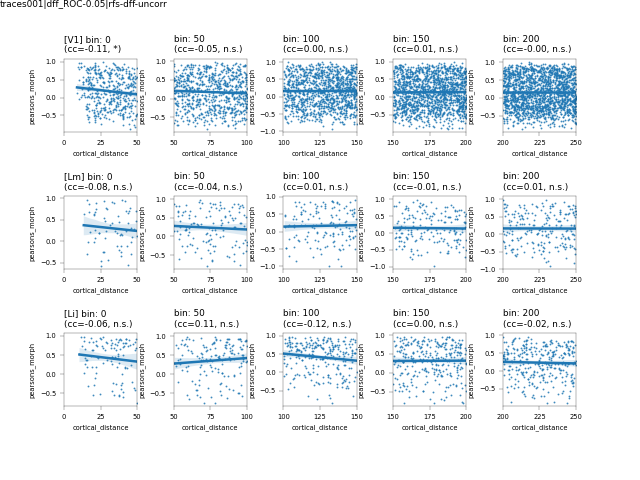

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning pearsons_morph_v_binCTX_50um


In [79]:
%matplotlib notebook
y_var='pearsons_morph'
dist_var = 'cortical_distance'
# -------------------------------------------------------------
dist_str='VF' if dist_var=='rf_distance' else 'CTX'
dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
dist_step = rf_step if dist_var=='rf_distance' else ctx_step
dist_unit = 'deg' if dist_var=='rf_distance' else 'um'
#
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,6))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_bin%s_%i%s' % (y_var, dist_str, dist_step, dist_unit)
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [52]:
df = DISTS.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

<IPython.core.display.Javascript object>


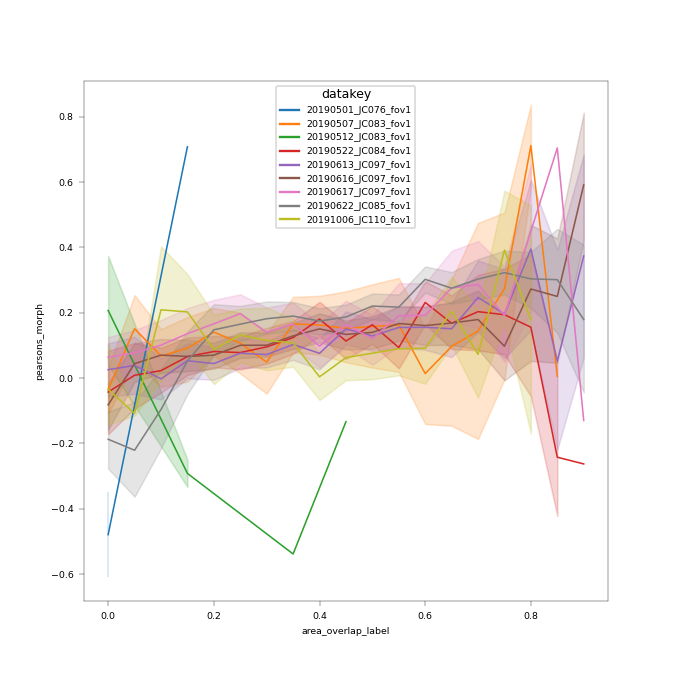

<AxesSubplot:xlabel='area_overlap_label', ylabel='pearsons_morph'>

In [55]:
%matplotlib notebook
y_var='pearsons_morph'
dist_var='area_overlap'

x_var ='%s_label' % dist_var

fig, ax = pl.subplots( figsize=(6,6), dpi=150)

va='V1'
vg = df[df.visual_area==va].copy()
sns.lineplot(x=x_var, y=y_var, data=vg, ax=ax,
            hue='datakey', lw=1)


In [63]:
df = DISTS.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

<IPython.core.display.Javascript object>


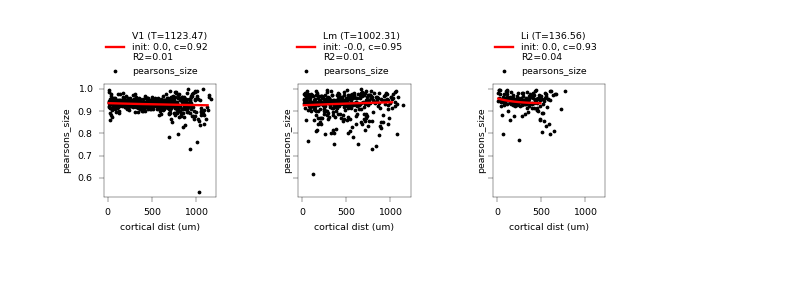

In [64]:
%matplotlib notebook
metric='pearsons_size'
to_quartile = 'cortical_distance'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)

xlabel='cortical dist (um)' if to_quartile=='cortical_distance' \
    else to_quartile
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), dpi=150, sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index() #.dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
    ax.set_box_aspect(1)
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [340]:
df = DISTS.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1000+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

# Split
dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step}           }

456


<IPython.core.display.Javascript object>


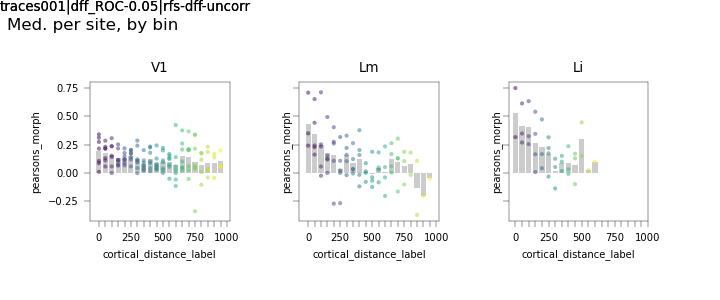

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning cortical_distance_label_v_pearsons_morph_barplot_byFOV


In [341]:
scale_ncells=False
plot_str='_scale-ncells' if scale_ncells else ''

# dist_var = 'rf_distance'
dist_var = to_quartile
x_var = '%s_label' % dist_var
max_dist = df[dist_var].max()
min_npairs=5
x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]

max_npairs = df.groupby(['visual_area', 'datakey', x_var])['neuron_pair'].count().max()
print(max_npairs)
fig, axn = pl.subplots(1,3, figsize=(6,2.5), dpi=150, sharex=False, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby([x_var, 'datakey'])['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>=min_npairs].index.tolist(),
                               cnts[cnts>=min_npairs].values))
    if len(nsamples_per)==0:
        ax.set_title('%s (too few cells)' % va)
        ax.set_box_aspect(1)
        continue
    # Sample
    cc_ = pd.concat([cg for c, cg in cc0.groupby([x_var, 'datakey']) \
                         if c in nsamples_per.keys()])
    by_fov = cc_.groupby([x_var, 'datakey']).median().reset_index()
    # Get counts
    cnt_df = cnts.reset_index().rename(columns={'neuron_pair': 'n_pairs'})
    cnts_and_vals = pd.merge(cnt_df[cnt_df['n_pairs']>=min_npairs], by_fov, 
                        on=['%s_label' % dist_var, 'datakey'], how='outer')
    sns.barplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax, ci=None, 
               color=[0.8]*3, zorder=-10000)
    
    cnts_and_vals['%s_ix' % x_var] = [x_bins.index(i) for i in cnts_and_vals[x_var]]
    if scale_ncells:
        sns.scatterplot(x='%s_ix' % x_var, y=metric, data=cnts_and_vals, ax=ax,
                     palette='viridis', hue=x_var, size='n_pairs',
                     sizes=(min_npairs, max_npairs), alpha=0.5,
                     size_norm=(min_npairs, max_npairs), edgecolor=None)
    else:
        sns.scatterplot(x='%s_ix' % x_var, y=metric, data=cnts_and_vals, ax=ax,
                 palette='viridis', hue=x_var, alpha=0.5, s=5, edgecolor=None) 
    ax.legend_.remove()
    ax.set_box_aspect(1)
    ax.set_title(va)
   # ax.set_ylim([0.8,1])
    ax.set_xticks(np.arange(0, len(x_bins)))
    if dist_var=='area_overlap':
        ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
    else:
        ax.set_xticklabels([int(i) if i in x_bins[0::5] else '' for i in x_bins])
pl.subplots_adjust(wspace=0.5)

fig.text(0.01, 0.9, 'Med. per site, by bin')
pplot.label_figure(fig, data_id)

pplot.label_figure(fig, data_id)
figname = '%s_v_%s_barplot_byFOV%s' % (x_var, metric, plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)



<IPython.core.display.Javascript object>


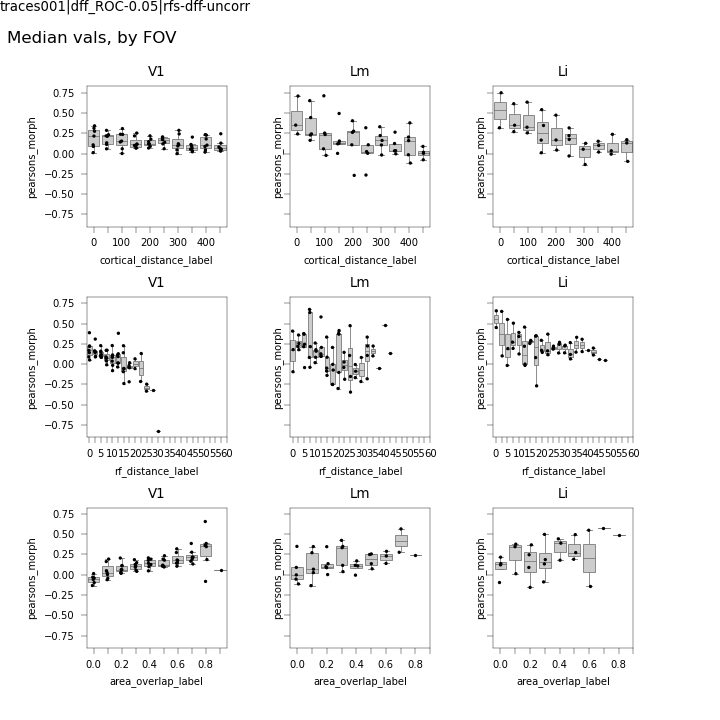

979
456
979
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning boxplot_pearsons_morph_v_dist-metrics


In [293]:
dist_var = 'rf_distance'
x_var = '%s_label' % dist_var

# Split distances into X um bins
ctx_step=50
ctx_maxdist=500
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
df = DISTS[DISTS.cortical_distance<=ctx_maxdist].copy().dropna(axis=0)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

# Split
dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step}           }

dist_vars=['cortical_distance', 'rf_distance', 'area_overlap']
fig, axn = pl.subplots(3,3, figsize=(6,6), dpi=150, sharex=False, sharey=True)
for ri, dist_var in enumerate(dist_vars):
    max_dist = df[dist_var].max()
    min_npairs=5
    x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]

    max_npairs = df.groupby(['visual_area', 'datakey', x_var])['neuron_pair'].count().max()
    print(max_npairs)
    x_var = '%s_label' % dist_var
    
    for va, cc0 in df.groupby('visual_area'):
        ax=axn[ri, visual_areas.index(va)]
        cnts = cc0.groupby([x_var, 'datakey'])['neuron_pair'].count()  
        # How many resample per group
        nsamples_per = dict((k, v) for k, v \
                            in zip(cnts[cnts>=min_npairs].index.tolist(),
                                   cnts[cnts>=min_npairs].values))
        if len(nsamples_per)==0:
            ax.set_title('%s (too few cells)' % va)
            ax.set_box_aspect(1)
            continue
        # Sample
        cc_ = pd.concat([cg for c, cg in cc0.groupby([x_var, 'datakey']) \
                             if c in nsamples_per.keys()])
        by_fov = cc_.groupby([x_var, 'datakey']).median().reset_index()
        # Get counts
        cnt_df = cnts.reset_index().rename(columns={'neuron_pair': 'n_pairs'})
        cnts_and_vals = pd.merge(cnt_df[cnt_df['n_pairs']>=min_npairs], by_fov, 
                            on=['%s_label' % dist_var, 'datakey'], how='outer')
        sns.boxplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax, fliersize=0, 
                   linewidth=0.5, color=[0.8]*3)
        sns.stripplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax,
                      size=2, color='k', alpha=1)
        ax.set_box_aspect(1)
        ax.set_title(va)

        x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]
        ax.set_xticks(np.arange(0, len(x_bins)))
        if dist_var=='area_overlap':
            ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
        else:
            ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])        

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, hspace=0.5)
fig.text(0.01, 0.94, 'Median vals, by FOV')

pplot.label_figure(fig, data_id)
figname = 'boxplot_%s_v_dist-metrics' % (metric)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)



In [87]:
x_bins

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9]

In [161]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=100
ctx_bins = np.arange(0, 800+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2
rf_bins = np.arange(0, 40+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')


In [162]:
# va='V1'
# plotd = df[df.visual_area==va].copy()
# len(plotd['datakey'].unique())
# for va, plotd in df.groupby('visual_area'):
#     print(va, len(plotd['datakey'].unique()))

In [163]:
x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons_morph'

In [164]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

<IPython.core.display.Javascript object>


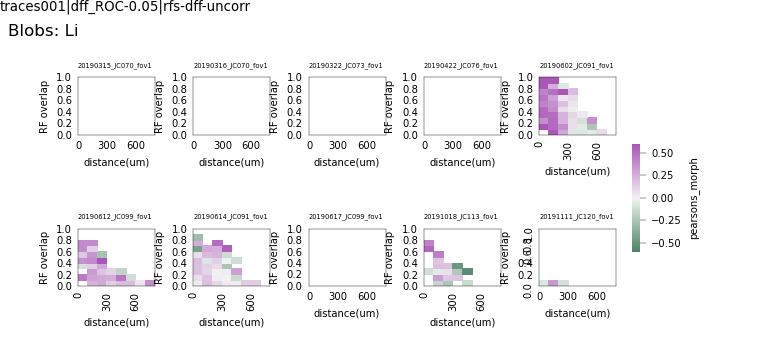

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning heatmaps_byFOV_Li_RFsimilarity_CXdist_tuning_pearsons_morph


<IPython.core.display.Javascript object>


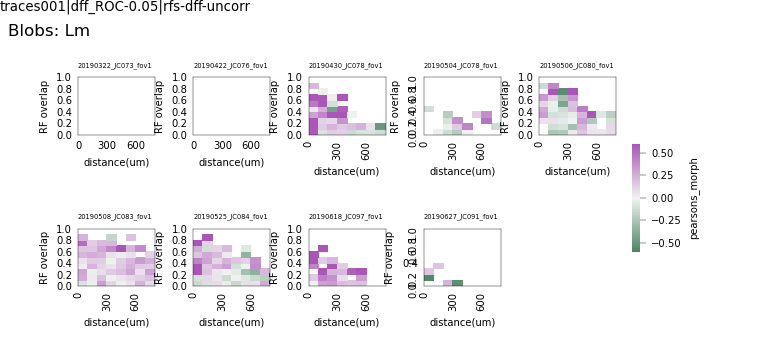

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning heatmaps_byFOV_Lm_RFsimilarity_CXdist_tuning_pearsons_morph


<IPython.core.display.Javascript object>


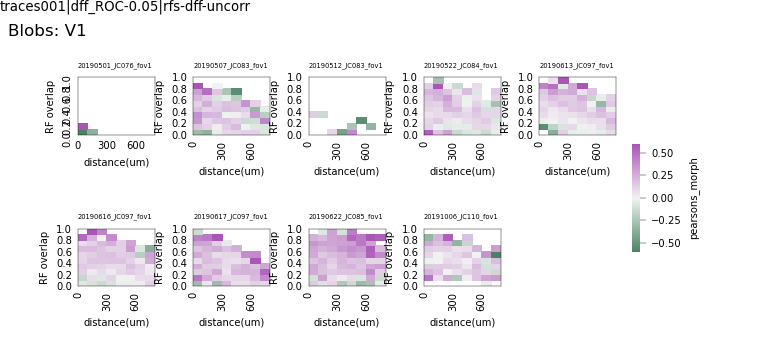

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning heatmaps_byFOV_V1_RFsimilarity_CXdist_tuning_pearsons_morph


In [165]:
nr=2
nc=5

x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons_morph'

hue_min, hue_max = (-.6, 0.6) if hue_var=='pearsons_morph' else (0.8, 1)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)


for va, plotd in df.groupby('visual_area'):
    fig, axn = pl.subplots(nr, nc, figsize=(6.5,3), dpi=150, sharex=False, sharey=False)
    cbar_ax = fig.add_axes([0.81, 0.3, 0.01, 0.3])

    grped_means = plotd.groupby(['%s_label' % x_var, '%s_label' % y_var]).mean()
    #hue_min, hue_max = grped_means[hue_var].min().min(), grped_means[hue_var].max().max()
    
    i=0
    for ai, (ax, (dk, df_)) in enumerate(zip(axn.flat, plotd.groupby('datakey'))):
        ax=cr.heatmap_tuning_v_distance(df_, x_bins, y_bins, ax=ax,
                                      x_var=x_var, y_var=y_var, 
                                      hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                      cmap=cmap, cbar=ai==0, #lw=0.5,
                                      cbar_ax=cbar_ax if ai==0 else None)
        ax.set_title(dk, loc='left', fontsize=4)
        ax.set_xlabel('distance(um)')
        ax.set_ylabel('RF overlap')
        i+=1

    for ai in np.arange(i, nr*nc):
        axn.flat[ai].axis('off')

    fig.text(0.01, 0.9, 'Blobs: %s' % va)
    pl.subplots_adjust(wspace=0.5, right=0.79, left=0.1)

    pplot.label_figure(fig, data_id)
    figname = 'heatmaps_byFOV_%s_RFsimilarity_CXdist_tuning_%s' % (va, hue_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)

<IPython.core.display.Javascript object>


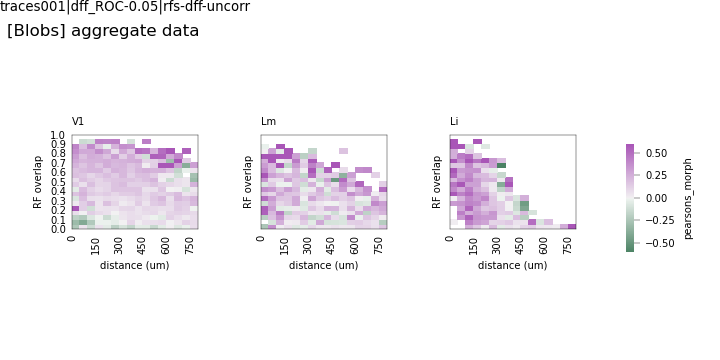

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning all_heatmaps_byFOV_RFsimilarity_CXdist_tuning_pearsons_morph


In [166]:
ctx_maxdist=800
ctx_step = 50
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.05
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')
# -----------------------------
x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons_morph'
#hue_min, hue_max = (-1, 1)
hue_min, hue_max = (-.6, 0.6) if hue_var=='pearsons_morph' else (0.8, 1)


cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.87, 0.3, 0.01, 0.3])
for ai, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = df_.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=1][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=1][y_var_name].unique()
    df0 = df_[(df_[x_var_name].isin(valid_x)) & (df_[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                  x_var=x_var, y_var=y_var, 
                                  hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                  cmap=cmap, cbar=ai==0, 
                                  cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    ax.set_ylabel('RF overlap')
    ax.set_xlabel('distance (um)')
fig.text(0.01, 0.9, '[Blobs] aggregate data')
pl.subplots_adjust(wspace=0.5, right=0.8, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'all_heatmaps_byFOV_RFsimilarity_CXdist_tuning_%s' % hue_var
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [167]:
'20190315_JC070_fov1' in rfdf['datakey'].unique()

False

In [ ]:
cnts = plotd.groupby([x_var_name, y_var_name])['neuron_pair'].count()


<IPython.core.display.Javascript object>


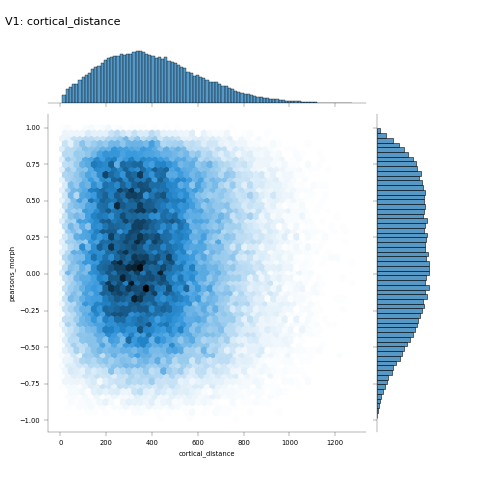

<IPython.core.display.Javascript object>


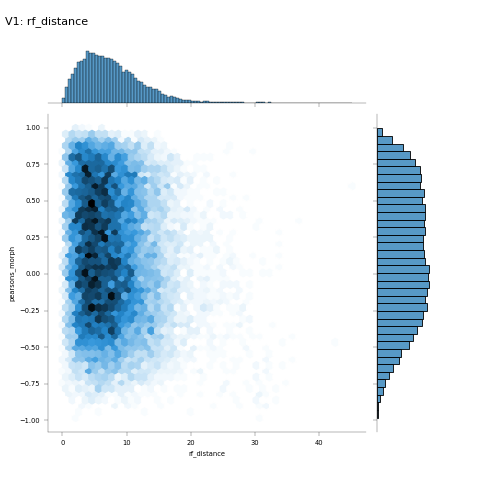

<IPython.core.display.Javascript object>


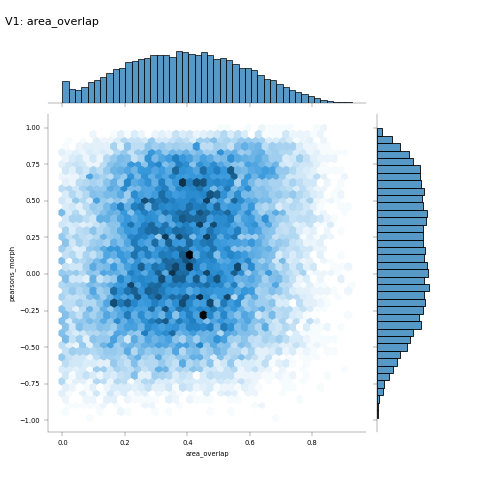

In [34]:
%matplotlib notebook
y_var='pearsons_morph'
for dist_var in ['cortical_distance', 'rf_distance', 'area_overlap']:
    fg = sns.jointplot(x=dist_var, y=y_var, data=plotd, 
                    kind='hex', height=6, )
    pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
    fg.fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
               fontsize=10)
    
    figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [53]:
min_ncells=50
plotd = df[df['n_cells']>=min_ncells]

In [54]:
df['visual_area'].unique()

array(['Li', 'Lm', 'V1'], dtype=object)

<IPython.core.display.Javascript object>


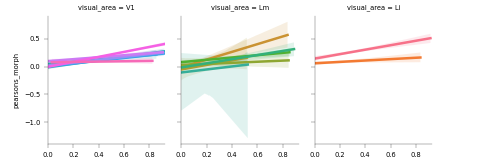

In [55]:
scatter_kws={'s':1}

fg = sns.FacetGrid(col='visual_area', col_order=visual_areas, 
                   hue='datakey', height=2, data=plotd)
fg.map(sns.regplot, dist_var, y_var,
            scatter_kws=scatter_kws, scatter=False)
# ax.legend_.remove()
pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
           fontsize=10)
figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)

In [189]:
import analyze2p.scatter as sct

In [342]:
dk='20190616_JC097_fov1'
va='V1'

ctx_maxdist=1000
equal_bins=False
n_bins=10

df = DISTS.copy()
# Split distances into X um bins
ctx_step=25
if equal_bins:
    ctx_bins = np.linspace(0, ctx_maxdist, n_bins)
else:
    ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
curr_maxdist = DISTS[(DISTS.visual_area==va) 
                    & (DISTS.datakey==dk)]['rf_distance'].max()
if equal_bins:
    rf_bins = np.linspace(0, curr_maxdist, n_bins)
else:
    rf_bins = np.arange(0, 40+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.05
if equal_bins:
    perc_bins = np.linspace(0, 1, n_bins)
else:
    perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')
# Split
dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step}           }

plotd = df[(df.cortical_distance<=ctx_maxdist)].copy().dropna()
vg = plotd[(plotd.datakey==dk) & (plotd.visual_area==va)].dropna()

<IPython.core.display.Javascript object>


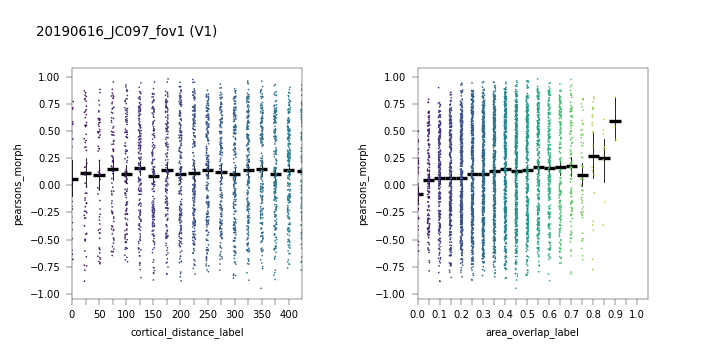

Text(0.05, 0.9, '20190616_JC097_fov1 (V1)')

In [354]:
%matplotlib notebook
scatter_kws={'s':0.5}
dist_vars = ['cortical_distance', 'area_overlap']
curr_ctx_maxdist = 400

r_list=[]

fig, axn = pl.subplots(1, 2, figsize=(6,3), dpi=150)

for ax, dist_var in zip(axn.flat, dist_vars):
    x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=curr_ctx_maxdist]
    curr_maxdist = max(x_bins)
    if x_var=='cortical_distance':
        df_ = vg[vg.cortical_distance<=curr_ctx_maxdist].copy()
    else:
        df_ = vg.copy()
        
    x_var = '%s_label' % dist_var
#     sns.boxplot( x=x_var, y='pearsons_morph', ax=ax,
#                 data=df_, fliersize=0, linewidth=0.5, width=0.8,
#                color=[0.8]*3)
    sns.stripplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, s=1, palette='viridis')
    sns.pointplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, scale=1, markers='_', join=False, color='k',
                 errwidth=0.5)

    ax.set_xticks(np.arange(0, len(x_bins)))
    if dist_var=='area_overlap':
        ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
    else:
        ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])        
    ax.set_xlim([0, len(x_bins)])
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5)

fig.text(0.05, 0.9, '%s (%s)' % (dk, va), fontsize=8)

<IPython.core.display.Javascript object>


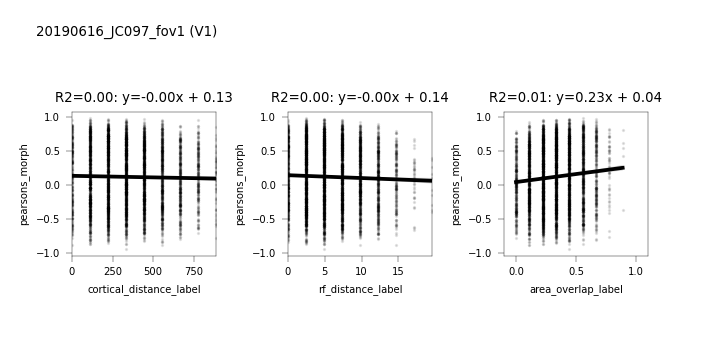

Text(0.05, 0.9, '20190616_JC097_fov1 (V1)')

In [336]:
%matplotlib notebook
scatter_kws={'s':0.5}
dist_vars = ['cortical_distance', 'rf_distance', 'area_overlap']
curr_ctx_maxdist = 800

r_list=[]

fig, axn = pl.subplots(1, 3, figsize=(6,3), dpi=150)

for ax, dist_var in zip(axn.flat, dist_vars):
    x_bins = dist_lut[dist_var]['bins']
    curr_maxdist = max(x_bins)
    if x_var=='cortical_distance':
        df_ = vg[vg.cortical_distance<=curr_ctx_maxdist].copy()
    else:
        df_ = vg.copy()
        
    x_var = '%s_label' % dist_var

    sns.regplot( x=x_var, y='pearsons_morph', ax=ax,
                data=df_, scatter_kws={'alpha':0.1, 's': 1}, color='k')
    # fit linear
    xvs = df_[x_var].values
    yvs = df_[y_var].values
    regr_, linmodel = sct.do_linear_fit(xvs, yvs, model='ridge')    
    regr_['dist_var'] = x_var 
    r_list.append(regr_)
    (r2, coef, intercept) = regr_[['R2', 'coefficient', 'intercept']].values[0]
    ax.set_title('R2=%.2f: y=%.2fx + %.2f' % (r2, coef, intercept))
    if 'area_overlap' in x_var:
        ax.set_xlim([-0.1, 1.1])

for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.1, wspace=0.5)

fig.text(0.05, 0.9, '%s (%s)' % (dk, va), fontsize=8)

In [279]:
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

<IPython.core.display.Javascript object>


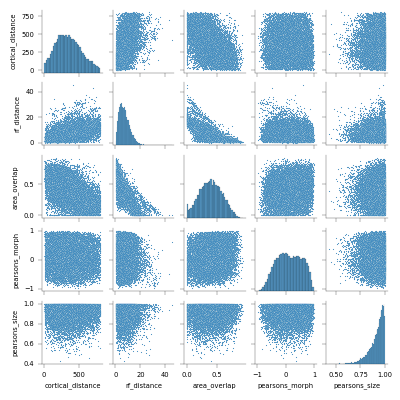

In [235]:
plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()

vg = plotd[plotd.visual_area==va]

sns.pairplot(data=vg, vars=['cortical_distance', 'rf_distance', 
                               'area_overlap','pearsons_morph', 'pearsons_size'],
            size=1, plot_kws={'s':1})


fg.fig.text(0.01, 0.95, '%s: %s' % (va, dist_var),
           fontsize=10)

figname = 'pairplots_V1'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


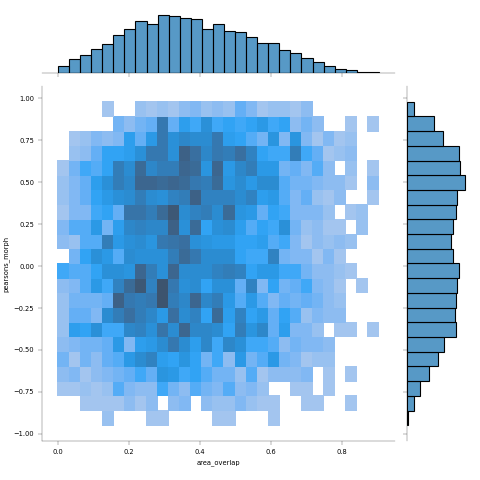

In [222]:
ctx_maxdist=1200
plotd = DISTS[(DISTS.cortical_distance<=ctx_maxdist)].copy().dropna()

dk='20190616_JC097_fov1'
va='V1'
df_ = plotd[(plotd.datakey==dk) & (plotd.visual_area==va)].dropna()

sns.jointplot(x=x_var, y=y_var, data=df_, ax=ax, kind='hist')

In [129]:
x_var

'cortical_distance'

In [77]:
df_.groupby(['datakey'])['neuron_pair'].count()  

datakey
20191006_JC110_fov1    3655
Name: neuron_pair, dtype: int64

## Bootstrap

In [24]:
df = DISTS.copy()
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

In [25]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='pearsons_morph'
to_quartile='area_overlap'
# --------------------------------------------------
cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=100
# Fit function
resdf = cr.bootstrap_fitdecay(df.dropna(), use_binned=use_binned, 
                         fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         bin_column='bin_value', normalize_x=True,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
    val out of bounds
    val out of bounds
    val out of bounds
(0, 6)


In [26]:

print("init: %i/%i iters too big" % (resdf[resdf.init>1].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<=-1].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>200].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.init<=0].shape[0], n_iterations))


init: 0/100 iters too big
init: 0/100 iters too small
tau: 0/100 iters too big
tau: 297/100 iters too small


In [27]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=1.2) & (resdf['init']>=-1.2) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(297, 6) (297, 6)


In [28]:
import _pickle as pkl


In [187]:
stim_str = '' 
select_stimuli='images'
if experiment in ['gratings', 'blobs']:
    if select_stimuli!='images':
        stim_str = '_FF' if select_stimuli=='fullfield' else '_%s' % select_stimuli

results_fpath = os.path.join(dst_dir, '%s_%s%s.pkl' % (to_quartile, bin_type, stim_str))
with open(results_fpath, 'wb') as f:
    pkl.dump(resdf, f, protocol=2)
print('saved: %s' % results_fpath)

saved: /n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning/area_overlap_cut-fitraw-avgfov.pkl


In [30]:
finalres.dropna().groupby('visual_area').count()

,init,tau,constant,R2,iteration
visual_area,,,,,
Li,97,97,97,97,97
Lm,100,100,100,100,100
V1,100,100,100,100,100


RF overlap (%)


<IPython.core.display.Javascript object>


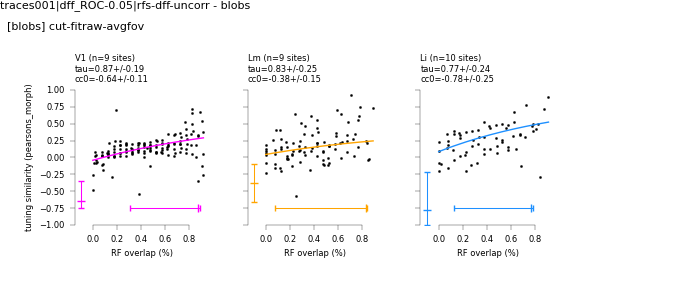

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning area_overlap_curves_cut-fitraw-avgfov


In [33]:
if to_quartile=='area_overlap':
    x_pos = -0.1
    xlabel='RF overlap (%)'
else:
    x_pos = -100 if to_quartile=='cortical_distance' else -10
    xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
ylabel='tuning similarity (%s)' % metric

print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 1), xlabel=xlabel, ylabel=ylabel)
fig.text(0.01, 0.9, '[%s] %s' \
             % (experiment, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_%s' % (to_quartile, bin_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### parameter estimates, 95% CI

<IPython.core.display.Javascript object>


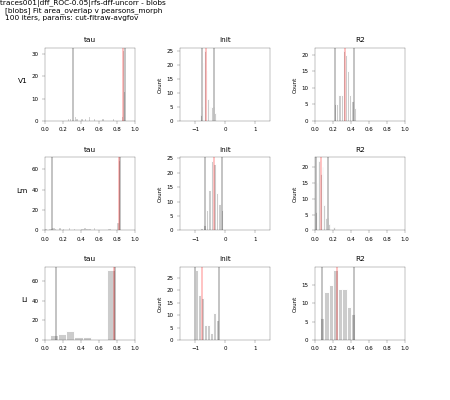

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning param_distns_area_overlap_cut-fitraw-avgfov


In [35]:
tau_lim=1200 if to_quartile=='cortical_distance' else 80
tau_lim = 1
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
for va, rd_ in finalres.groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.5)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.95, "[%s] Fit %s v %s\n%i iters, params: %s" 
    % (experiment, to_quartile, metric, n_iterations, bin_type), 
         fontsize=8)

figname = 'param_distns_%s_%s' % (to_quartile, bin_type)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


RF distance (deg)


<IPython.core.display.Javascript object>


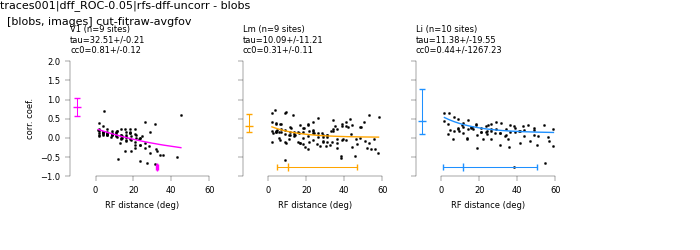

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning rf_distance_curves_cut-fitraw-avgfov


In [72]:
x_pos = -100 if to_quartile=='cortical_distance' else -10
xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, xlabel=xlabel,
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 2), )
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_%s%s' % (to_quartile, bin_type, stim_str)
#pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [559]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/blobs_dff_ROC/morph_tuning'

In [516]:
va='V1'
dk='20190616_JC097_fov1'
df_ = avg_responses[(avg_responses.visual_area==va) & (avg_responses.datakey==dk)]

In [519]:

posdf_ = aggr.add_roi_positions(df_)
if rfdf is not None:
    posdf0 = posdf_.copy()
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf_ = cr.get_roi_pos_and_rfs(posdf0, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if posdf_.shape[0]==0:
        print(va, dk)

In [520]:
posdf_

,visual_area,datakey,cell,ml_pos,ap_pos,x0,y0
0,V1,20190616_JC097_fov1,0,909.977299,1078.506458,34.263130,-10.628686
1,V1,20190616_JC097_fov1,1,864.288063,1099.246967,NaN,NaN
2,V1,20190616_JC097_fov1,2,852.865753,1073.897456,30.848143,-6.732552
3,V1,20190616_JC097_fov1,9,873.806654,1023.198434,39.429009,-3.330024
4,V1,20190616_JC097_fov1,11,883.325245,993.239922,35.470047,-12.506376
...,...,...,...,...,...,...,...
180,V1,20190616_JC097_fov1,424,207.505284,1048.547945,29.780096,-2.802732
181,V1,20190616_JC097_fov1,425,32.363209,772.007828,20.431419,-7.071060
182,V1,20190616_JC097_fov1,426,45.689237,811.184344,NaN,NaN
183,V1,20190616_JC097_fov1,429,138.971429,520.817221,20.485330,-13.131780


In [524]:

cc = cr.get_pw_curve_correlations(df_, stimulus='blobs')
diffs_ = cc.copy()

if 'x0' in posdf_.columns:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = cr.get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)


In [526]:
adist.head()

,xcorr_morph,pearsons_morph,cosim_morph,cell_1,cell_2,neuron_pair,xcorr_size,pearsons_size,cosim_size,rf_distance,max_ecc,min_ecc,cortical_distance
0,3.502203,-0.030559,0.876929,0,1,0_1,1.900788,0.848862,0.958029,NaN,NaN,NaN,50.176439
1,2.839756,0.780673,0.942752,0,2,0_2,1.832618,0.920442,0.977413,5.180927,35.873821,31.574280,57.297221
2,3.129756,0.676105,0.936768,0,9,0_9,1.694492,0.994842,0.991813,8.941855,39.569379,35.873821,66.085498
3,2.824641,-0.381755,0.813232,0,11,0_11,1.768774,0.915901,0.965303,2.232122,37.610287,35.873821,89.334843
4,2.598988,0.200115,0.860275,0,12,0_12,2.073319,0.958303,0.991609,9.247455,40.524749,35.873821,129.947597


In [486]:
no_rfs=[]

curr_rfs=None
if rfdf is not None:
    curr_rfs = rfdf[(rfdf.visual_area==va) & (rfdf.datakey==dk)].copy()
    posdf = cr.get_roi_pos_and_rfs(df_, curr_rfs, rfs_only=False, 
                                merge_cols=['visual_area', 'datakey', 'cell'])
    if curr_rfs.shape[0]==0:
        no_rfs.append((va, dk, exp))
else:
    posdf = aggr.add_roi_positions(df_)
no_rfs

[]

In [490]:
posdf_ = aggr.add_roi_positions(df_)
posdf_

,visual_area,datakey,cell,config,response,size,morphlevel,experiment,animalid,fov,session,fov_xpos,fov_xpos_pix,fov_ypos,fov_ypos_pix,ml_pos,ap_pos
0,V1,20190616_JC097_fov1,0,config006,0.073549,10.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
1,V1,20190616_JC097_fov1,0,config007,0.062874,20.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
2,V1,20190616_JC097_fov1,0,config008,0.089596,30.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
3,V1,20190616_JC097_fov1,0,config009,0.102889,40.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
4,V1,20190616_JC097_fov1,0,config010,0.181599,50.0,0,blobs,JC097,FOV1_zoom2p0x,20190616,99.093542,43.0,62.822701,33.0,909.977299,1078.506458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8320,V1,20190616_JC097_fov1,431,config046,0.047672,10.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8321,V1,20190616_JC097_fov1,431,config047,0.014780,20.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8322,V1,20190616_JC097_fov1,431,config048,0.016424,30.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890
8323,V1,20190616_JC097_fov1,431,config049,0.016479,40.0,106,blobs,JC097,FOV1_zoom2p0x,20190616,258.104110,112.0,287.461448,151.0,685.338552,919.495890


In [ ]:

cc = get_pw_curve_correlations(df_, n_intervals=n_intervals, stimulus=stimulus)
diffs_ = cc.copy()

# # Cortical and RF difff
# if 'ml_pos' not in df_.columns:
#     if stimulus=='blobs':
#         posdf0 = df_[['visual_area', 'datakey', 'experiment', 'cell']].drop_duplicates()
#     else:
#         posdf0 = df_.copy()
#     posdf_ = aggr.add_roi_positionsS(posdf0)
# else:
#     posdf_ = df_.copy()        

if 'x0' in posdf_.columns:
    adist = get_pw_distance(diffs_, posdf_, xcoord='x0', ycoord='y0', 
                             label='rf_distance', add_eccentricity=True)
else:
    adist = get_pw_distance(diffs_, posdf_, xcoord='ml_pos', ycoord='ap_pos', 
                             label='cortical_distance', add_eccentricity=False)

assert adist.shape[0]==cc.shape[0], 'Bad merging: %s, %s' (va, dk)